In [2]:
import os 

os.chdir("..")

# print(os.getcwd())

In [ ]:
from pathlib import Path

import torch
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf
from ase.optimize import LBFGS
from ase import Atoms
from ase.constraints import FixAtoms
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from ase.visualize.plot import plot_atoms

from dataset import BaseDataset
from model import calc_dmae_mic

def plot_ase_atoms(atoms):
    plot_atoms(atoms.repeat((3, 3, 1)), radii=1.0).axis('off')

checkpoint_path = Path("UMA") / "uma-s-1p1.pt"
atomic_refs_path = Path("UMA") / "iso_atom_elem_refs.yaml"

stage = 'val'
data_path = Path("data/cathub") / f"{stage}.pkl"
dataset = BaseDataset(data_path)

atom_refs = OmegaConf.load(atomic_refs_path)
predictor = load_predict_unit(checkpoint_path, device="cuda", atom_refs=atom_refs)
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [4]:
idx_list = []
idx_OH = []

for idx, data in tqdm(enumerate(dataset), total=len(dataset)):
    if data.atomic_numbers[
        (data.atomic_numbers > 20) | (data.atomic_numbers == 13)
    ].unique().size(0) == 1:
       # print(f"idx: {idx}, atomic_numbers: \
       #     {data.atomic_numbers[(data.atomic_numbers > 20) | (data.atomic_numbers == 13)]}")
        idx_list.append(idx)
        if (data.atomic_numbers == 8).any() and (data.atomic_numbers == 1).any():
            if (data.atomic_numbers == 1).sum() == 1:
                idx_OH.append(idx)

100%|██████████| 14728/14728 [00:00<00:00, 55289.52it/s]


In [8]:
idx = idx_list[-36] 
data = dataset[idx]

atomic_numbers = data.atomic_numbers.numpy()
cell = data.cell.squeeze().numpy()
positions = data.pos.numpy()
fixed = torch.where(data.fixed != 0)[0].numpy()

slab = Atoms(numbers=atomic_numbers, cell=cell, positions=positions, pbc=True)
print(slab)
constraint = FixAtoms(indices=fixed)
slab.set_constraint(constraint)
slab.calc = calc

# Set up LBFGS dynamics object
dyn = LBFGS(slab, trajectory="tmp/slab.traj")
dyn.run(0.05, 200)

pos1 = torch.matmul(data.pos_relaxed, data.cell.squeeze().inverse())
pos2 = torch.matmul(
    torch.tensor(slab.positions, dtype=torch.float32), data.cell.squeeze().inverse()
)
dmae = calc_dmae_mic(pos1, pos2, data.cell.squeeze()).item()

shift = pos1 - pos2
shift = shift - torch.floor(shift + 0.5)
shift_cart = torch.matmul(shift, data.cell.squeeze())

print('dmae_item: ', dmae)

pos_relaxed = torch.tensor(slab.positions, dtype=torch.float32)

Atoms(symbols='Y12C', pbc=True, cell=[[7.028248310089111, 0.0, 0.0], [3.5141236782073975, 6.086641788482666, 0.0], [0.0, 0.0, 25.73853874206543]])
       Step     Time          Energy          fmax
LBFGS:    0 14:03:16      -71.347594        2.496762
LBFGS:    1 14:03:16      -71.500378        2.572937
LBFGS:    2 14:03:16      -70.685234        2.209874


LBFGS:    3 14:03:16      -69.949473        1.809060
LBFGS:    4 14:03:16      -69.320258        1.547344
LBFGS:    5 14:03:16      -68.798046        1.671243
LBFGS:    6 14:03:16      -68.372315        1.793483
LBFGS:    7 14:03:16      -68.041085        1.891593
LBFGS:    8 14:03:16      -67.794384        1.949816
LBFGS:    9 14:03:16      -68.052426        1.872932
LBFGS:   10 14:03:16      -68.338608        1.823743
LBFGS:   11 14:03:16      -68.105404        1.802933
LBFGS:   12 14:03:16      -67.944634        1.752479
LBFGS:   13 14:03:16      -68.123204        1.775446
LBFGS:   14 14:03:16      -68.338887        1.810753
LBFGS:   15 14:03:16      -68.157929        1.731683
LBFGS:   16 14:03:16      -68.034687        1.636152
LBFGS:   17 14:03:16      -68.172091        1.710238
LBFGS:   18 14:03:16      -68.343829        1.793478
LBFGS:   19 14:03:16      -68.194767        1.683162
LBFGS:   20 14:03:16      -68.092623        1.565634
LBFGS:   21 14:03:17      -68.204989        1.

In [9]:
from trainer.pl_cart import pl_module_cart
from model import InferenceModel, calc_dmae_mic
from model.net import AdsPaiNN

batch_size = 1
model_path = 'checkpoints/scorenet-epoch=099-avg_val_loss=0.062.ckpt'
torch.serialization.add_safe_globals([AdsPaiNN])
model = pl_module_cart.load_from_checkpoint(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inference_model = InferenceModel(model, [data], batch_size, device)

# ODE sampling 
steps = 20
eta = 0.0
dbcata_gs = inference_model.inference(steps, eta, device)


data_generated = dbcata_gs[0]
pos_generated = data_generated.pos_generated
cell_generated = data_generated.cell.squeeze()
atomic_numbers_generated = data_generated.atomic_numbers
slab_generated = Atoms(
    numbers=atomic_numbers_generated, cell=cell_generated, positions=pos_generated, pbc=True
)
slab_generated.set_constraint(constraint)
slab_generated.calc = calc

energy_generated = slab_generated.get_potential_energy()

Inferencing BBDM: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

========================Inference Results============================
Inference time: 0h 0m 0.11s for 20 steps BBDM with eta 0.0
END with totol data length: 1, error: 0
==============================END====================================


In [10]:
slab_relaxed = Atoms(numbers=atomic_numbers, cell=cell, positions=data.pos_relaxed.numpy(), pbc=True)
# slab_relaxed = Atoms(numbers=atomic_numbers, cell=cell, positions=pos, pbc=True)
slab_relaxed.set_constraint(constraint)
slab_relaxed.calc = calc

energy = slab.get_potential_energy()
energy_relaxed = slab_relaxed.get_potential_energy()
print(f"energy_relaxed: {energy_relaxed}, energy_uma: {energy}, energy_generated: {energy_generated}")

energy_relaxed: -75.56756054825283, energy_uma: -68.4314559645126, energy_generated: -75.55003582901455


In [11]:
slab_generated_ = slab_generated.copy()
slab_generated_.calc = calc
dyn = LBFGS(slab_generated_, trajectory="tmp/slab_generated.traj")
dyn.run(0.05, 200)
slab_generated_.get_potential_energy()

       Step     Time          Energy          fmax
LBFGS:    0 14:05:20      -75.550036        0.239483
LBFGS:    1 14:05:20      -75.551319        0.210825
LBFGS:    2 14:05:20      -75.555348        0.125131
LBFGS:    3 14:05:20      -75.556233        0.135409
LBFGS:    4 14:05:20      -75.567616        0.229287
LBFGS:    5 14:05:20      -75.573012        0.189169
LBFGS:    6 14:05:20      -75.577660        0.061329
LBFGS:    7 14:05:20      -75.577855        0.056017
LBFGS:    8 14:05:20      -75.578356        0.076308
LBFGS:    9 14:05:20      -75.579941        0.105528
LBFGS:   10 14:05:20      -75.581482        0.095504
LBFGS:   11 14:05:20      -75.582343        0.047118


-75.58234250015713

In [12]:
from model.visualize import draw_ase_atoms

draw_ase_atoms(slab_relaxed.repeat((3, 3, 1)))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
def get_distances_unconstrained(atoms):
    unconstrained_atoms = atoms[np.array(
        [i not in list(atoms.constraints[0].index) for i in range(len(atoms))]
        )]
    return unconstrained_atoms.get_all_distances()

# read traj file
from ase.io import read

slab_list = read("tmp/slab.traj", index=":")
slab_generated_list = read("tmp/slab_generated.traj", index=":")

In [15]:
np.random.seed(42)

# Enhance datas with randomly perturbed structures
def get_perturbed_slabs(slab, num_perturbations=10, perturbation_scale=0.1):
    perturbed_slabs = []
    for _ in tqdm(range(num_perturbations), total=num_perturbations, desc="Generating perturbed slabs"):
        perturbed_positions = slab.positions + perturbation_scale * np.random.randn(*slab.positions.shape)
        perturbed_slab = slab.copy()
        perturbed_slab.set_positions(perturbed_positions)
        perturbed_slab.calc = calc
        perturbed_slabs.append(perturbed_slab)
    return perturbed_slabs

_perturbed_slabs = get_perturbed_slabs(slab_list[-1])
slab_list += _perturbed_slabs
_perturbed_slabs = get_perturbed_slabs(slab_list[0])
slab_list += _perturbed_slabs
_perturbed_slabs = get_perturbed_slabs(slab_generated_list[-1])
slab_list += _perturbed_slabs
_perturbed_slabs = get_perturbed_slabs(slab_generated_list[0])
slab_list += _perturbed_slabs

# UMA structures + perturbed structures
D = [get_distances_unconstrained(slab) for slab in slab_list]
energies = [slab.get_potential_energy() for slab in slab_list]


# DBCata Structures 
len_slab_generated_list = len(slab_generated_list) + 1
D += [get_distances_unconstrained(slab_generated) for slab_generated in slab_generated_list]
energies += [slab_generated.get_potential_energy() for slab_generated in slab_generated_list]

# DFT
D += [get_distances_unconstrained(slab_relaxed)]
energies += [slab_relaxed.get_potential_energy()]

Generating perturbed slabs: 100%|██████████| 10/10 [00:00<00:00, 38908.20it/s]


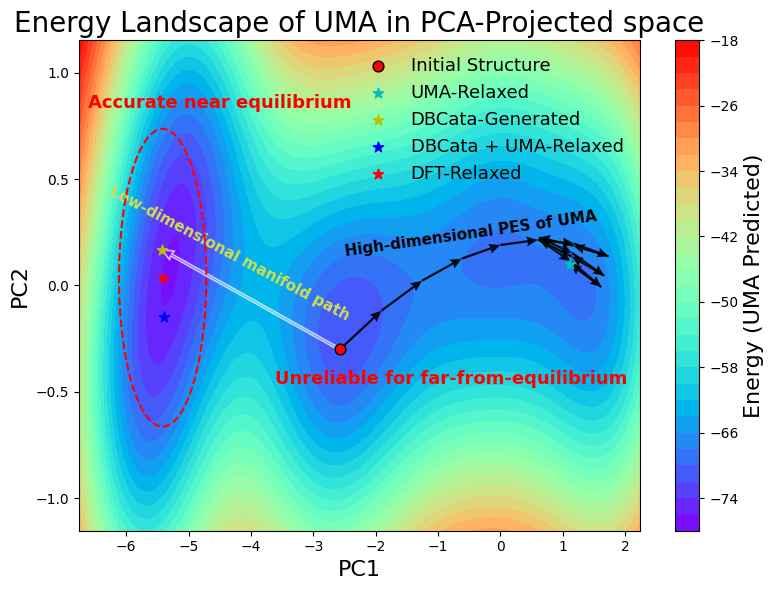

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

D = np.array(D)  # [M, N, N]
energies = np.array(energies)  # [M, ]
M = D.shape[0]

# -----------------------------
# Flatten to features S
X = D.reshape(M, -1)  # [M, N*N]

# -----------------------------
# PCA to 2D
# -----------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)  # [M, 2]

# -----------------------------
# Scatter plot (2D embedding colored by energy)
# -----------------------------
# plt.figure()
# sc = plt.scatter(X2[:,0], X2[:,1], c=energies, s=12)
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("2D embedding (PCA) colored by energy")
# cbar = plt.colorbar(sc)
# cbar.set_label("Energy (arb. units)")
# plt.tight_layout()
# plt.show()

# -----------------------------
#  Smooth energy surface over the 2D embedding
#  (Kernel Ridge with RBF kernel on (PC1, PC2) -> E, then contourf)
# -----------------------------
# Fit smoother
krr = KernelRidge(alpha=1e-1, kernel="rbf", gamma=None)
krr.fit(X2, energies)

# Make a grid
nx = ny = 200
xg = np.linspace(X2[:,0].min()-1, X2[:,0].max()+0.5, nx)
yg = np.linspace(X2[:,1].min()-0.5, X2[:,1].max()+0.5, ny)
XX, YY = np.meshgrid(xg, yg)
grid = np.column_stack([XX.ravel(), YY.ravel()])
Ez = krr.predict(grid).reshape(ny, nx)

plt.figure(figsize=(8, 6), dpi=100)
cs = plt.contourf(XX, YY, Ez, levels=33, cmap="rainbow", alpha=1.0)
plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.title("Energy Landscape of UMA in PCA-Projected space", fontsize=20)
cbar2 = plt.colorbar(cs)
cbar2.set_label("Energy (UMA Predicted)", fontsize=16)

# arrows
x, y = X2[1:18, 0], X2[1:18, 1]
dx, dy = np.diff(x), np.diff(y)

# path of uma
plt.quiver(
    x[:-1], y[:-1], dx, dy,
    angles='xy', scale_units='xy', scale=1, 
    width=0.004, headwidth=4.5, headlength=5, headaxislength=4.5,
    color='k', alpha=0.9, zorder=3
)

plt.scatter([x[0]], [y[0]], s=60, facecolors='r', edgecolors='k', zorder=4, label='Initial Structure')
plt.scatter([x[-1]], [y[-1]], s=60, marker='*', color='c', zorder=4, label='UMA-Relaxed')

# path of DBCata
x, y = X2[[1, -len_slab_generated_list], 0], X2[[1, -len_slab_generated_list], 1]
dx, dy = np.diff(x), np.diff(y)
plt.quiver(
    x[:-1], y[:-1], dx, dy,
    angles='xy', scale_units='xy', scale=1,
    width=0.004, headwidth=4.5, headlength=5, headaxislength=4.5,
    facecolor='none',            
    edgecolors='w',              
    linewidths=1.2,              
    linestyles='-',             
    alpha=0.7, zorder=3
)
plt.scatter([x[-1]], [y[-1]], s=60, marker='*', color='y', zorder=4, label='DBCata-Generated')

# path of DBCata-uma
x, y = X2[-len_slab_generated_list:, 0], X2[-len_slab_generated_list:, 1]
dx, dy = np.diff(x), np.diff(y)

plt.scatter([x[-2]], [y[-2]], s=60, marker='*', color='b', zorder=4, label='DBCata + UMA-Relaxed')
plt.scatter([x[-1]], [y[-1]], s=60, marker='*', color='r', zorder=4, label='DFT-Relaxed')

# Draw a circle around the local minimum
ax = plt.gca()
circle = Circle((x[-1], y[-1]), 0.7, fill=False, edgecolor='r',
                linestyle='--', linewidth=1.5, zorder=5)
ax.add_patch(circle)

ax.text(
    x[-1] - 1.2, y[-1] + 0.8, 'Accurate near equilibrium', c="r", fontsize=13, fontweight='bold'
)
ax.text(
    x[-1] + 1.8, y[-1] - 0.5, 'Unreliable for far-from-equilibrium', 
    c="r", fontsize=13, fontweight='bold'
)
ax.text(
    x[-1] - 0.9, y[-1]-0.2, 'Low-dimensional manifold path', c="#CEDF4E", 
    fontsize=11, fontweight='bold', rotation=-28
)

ax.text(
    x[-1] + 2.9, y[-1]+0.1, 'High-dimensional PES of UMA', c="k", 
    fontsize=11, fontweight='bold', rotation=8
)

plt.legend(loc='upper right', frameon=False, fontsize=13)
plt.tight_layout()
plt.show()
# c="#D00909"